In [40]:
import random
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import cycle

In [37]:
### TO DO
# 1) '(?)' nodes replacement should be done by UM/DM
# 2) Remove Invalid tid rows in df


In [68]:
# Trace builiding code
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    use_columns = list(range(9)) 
    df = pd.read_csv(file,delimiter=',', usecols=use_columns)
    return df

def extract_traceid_rows(df, tid):
    '''
    Returns a list of rpc calls in tid
    '''
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls

def df_to_trace_edges_dict(df):
    '''
    Args: Alibaba traces dataframe
    Return: Dict, Key:tid, Val:list of edges
    '''
    tids_list = df['traceid'].unique().tolist()
    traces_edges = {}
    for i in tqdm(range(len(tids_list))):
        tid_calls = extract_traceid_rows(df, tids_list[i])
        t_edges = [] # list of edges of trace
        for call in tid_calls:
            t_edges.append([call.um, call.dm])
        traces_edges[tids_list[i]] = t_edges
    return traces_edges

def get_valid_traces(df):
    '''
    Trace is valid only if Initial node details are available.
    Discard trace if initial node details not available.
    Modifies df in place.
    Args: List of tids in original trace.
    Returns: List of valid tids.
    '''
    tids_list = df['traceid'].unique().tolist()
    valid_tids_list = []
    invalid_tids = []
    for i in tqdm(range(len(tids_list)), desc='Getting valid tids...'):
        tid_calls = extract_traceid_rows(df, tids_list[i])
        initial_node = ''
        for call in tid_calls:
            if call.rpcid == "0":
                initial_node = call.dm
                valid_tids_list.append(tids_list[i])
        if initial_node == '':
            invalid_tids.append(tids_list[i])
            # df = df[df['traceid'] != tids_list[i]]
            
    # Remove all invalid tid rows
    print('Num Valid tids: ', len(valid_tids_list))
    print('Num Invalid tids: ',len(invalid_tids))
    df = df[~df['traceid'].isin(invalid_tids)]
    return valid_tids_list, df

def get_call_depth(rpc_id):
    if rpc_id == "0":
        return 1
    else:
        call_depth = 0
        for i in rpc_id:
            if i == ".":
                call_depth += 1
    return call_depth

def save_dict_as_pkl(traces_dict, file_name):
    with open(file_name+'.pkl', 'wb') as pkl_file:
        pickle.dump(traces_dict, pkl_file)

def pkl_to_dict(file_path):
    with open(file_path, 'rb') as pkl_file:
        T_prime = pickle.load(pkl_file)
    return T_prime

def correct_unknown_node_err(df):
    '''
    Replaces '(?)' with a random node
    '''
    sf_nodes_list = df.loc[(df['rpctype'] == 'db') & (df['dm'] != '(?)'), 'dm'].unique().tolist()
    sl_nodes_list = df.loc[(df['rpctype'] != 'db') & (df['dm'] != '(?)'), 'dm'].unique().tolist()

    rand_sf_nids = random.sample(sf_nodes_list, len(sf_nodes_list))
    rand_sl_nids = random.sample(sl_nodes_list, int(len(sl_nodes_list)/2))

    # Randomly assign nodeids to unknown nodes
    um_mask = df['um'] == '(?)'
    dm_mask = df['dm'] == '(?)'
    sf_mask = df['rpctype'] == 'db'
    sl_mask = df['rpctype'] != 'db'

    # Replace UM unknow nodes
    df.loc[um_mask & sf_mask, 'um'] = np.random.choice(rand_sf_nids)
    df.loc[um_mask & sl_mask, 'um'] = np.random.choice(rand_sl_nids)
    # Replace DM unknow nodes
    df.loc[dm_mask & sf_mask, 'dm'] = np.random.choice(rand_sf_nids)
    df.loc[dm_mask & sl_mask, 'dm'] = np.random.choice(rand_sl_nids)

    return df

In [ ]:
'''
Clean & Store alibaba trace
Extract valid tids and replace unknown nodes.
'''
'''
<UNCOMMENT IF NEED TO CLEAN DATASET>

# Extract to dataframe
df = csv_to_df("./casper_rebuild.csv")

# Extract all valid tids
tids_list, df = get_valid_traces(df)

# Replace Unknown nodes 
df = correct_unknown_node_err(df)

unique_nodes = list(set(df['um'].unique().tolist() + df['dm'].unique().tolist()))
num_traces = len(tids_list)
df.to_csv('casper_rebuild_cleaned.csv', index=False)
print("Num of tids (traces): ", num_traces)
print("Num of unique nodes: ", len(unique_nodes))

'''

In [71]:
df = csv_to_df("./casper_rebuild_cleaned.csv")

tids_list = df['traceid'].unique()
num_traces = len(tids_list)
unique_nodes = list(set(df['um'].unique().tolist() + df['dm'].unique().tolist()))
print("Num of tids (traces): ", num_traces)
print("Num of unique nodes: ", len(unique_nodes))

Num of tids (traces):  4439
Num of unique nodes:  3092


In [72]:
'''
NIS calc
Node Metrics: [type, NIS]
'''
nis_dict = {}
node_type_dict = {} # Create Node type dict, Key: node id, Val: Type
ctr = 0
for row in tqdm(df.itertuples(), total=len(df), desc='Calculating NIS...'):
    ctr += 1
    um_node = row.um
    dm_node = row.dm

    # Update node type dict for dm_node
    if dm_node not in node_type_dict:
        node_type_dict[dm_node] = row.rpctype

    # Update nis dict for um_node
    if um_node in nis_dict:
        if row.traceid not in nis_dict[um_node]:
            nis_dict[um_node].append(row.traceid)
    else:
        nis_dict[um_node] = [row.traceid]
    # Update nis dict for dm_node
    if dm_node in nis_dict:
        if row.traceid not in nis_dict[dm_node]:
            nis_dict[dm_node].append(row.traceid)
    else:
        nis_dict[dm_node] = [row.traceid]

print(len(node_type_dict))
# replace traceid list with NIS
# num_traces = 4439 ### TO BE REPLACED
for node in nis_dict:
    nis_dict[node] = set(nis_dict[node])
    nis = len(nis_dict[node])/num_traces ### TO BE REPLACED
    nis_dict[node] = [round(nis,7)]

# save_dict_as_pkl(node_type_dict, 'downsampled_graphs/node_type_data')

Calculating NIS...: 100%|██████████| 205722/205722 [00:02<00:00, 80461.65it/s] 

3086


In [96]:

print(len(nis_dict))

3092


In [73]:
'''
Trace metrics calc
Trace Metrics: [trace_depth, TIS, initial_node, num_sf, num_sl]
'''

trace_met_dict = {} # Key: tid, Val: [trace_depth, tis, initial_node, t_sf_ctr, t_sl_ctr]
cd_strat_dict = {} # dict. key: cd, val: [tid ,tis]
ini_nodes = []
check = 0
for i in tqdm(range(len(tids_list)), desc='Trace Metrics Calculation...'):
    ctr = 0
    tid_calls = extract_traceid_rows(df, tids_list[i])
    initial_node = ""
    t_edges = [] # list of edges of trace
    t_sf_ctr = 0
    t_sl_ctr = 0
    trace_depth = 0
    for call in tid_calls:
        t_edges.append([call.um, call.dm])
        call_depth = get_call_depth(call.rpcid)
        if call_depth > trace_depth: # update trace depth
            trace_depth = call_depth
        if call.rpcid == "0": # get initial node of trace
            check += 1
            initial_node = call.dm
            # print(initial_node)
        if call.rpctype == "db": # get sf sl node count
            t_sf_ctr += 1
        else: 
            t_sl_ctr += 1

    # TIS calculation
    t_nodes = []
    for edge in t_edges:
        for node in edge:
            if node not in t_nodes:
                t_nodes.append(node)
    tis = 0
    for node in t_nodes:
        nis_temp = nis_dict[node][0]
        tis += nis_temp 
    tis = tis/len(t_nodes)

    # Collecting data for stratification
    if trace_depth not in cd_strat_dict:
        cd_strat_dict[trace_depth] = []
    cd_strat_dict[trace_depth].append([tids_list[i],tis])

    trace_met_dict[tids_list[i]] = [trace_depth, tis, initial_node, t_sf_ctr, t_sl_ctr]

# save_dict_as_pkl(trace_met_dict, 'downsampled_graphs/trace_details_data')

Trace Metrics Calculation...: 100%|██████████| 4439/4439 [00:42<00:00, 104.21it/s]


In [74]:
'''
Stratification
'''

cd_percent_arr = [] # [valid call depth, % of tids of resp cd]
# ctr is used as the total num of tids

# Collecting cd percentage in the original trace
for cd in cd_strat_dict:
    percent_t_cd = 100 * (len(cd_strat_dict[cd])/num_traces)
    cd_percent_arr.append([cd, percent_t_cd])
    cd_strat_dict[cd] = sorted(cd_strat_dict[cd], key=lambda x: x[1], reverse=True) # sorting tids based on tis


In [75]:
cd_percent_arr.sort(key=lambda x: x[0])
print(cd_percent_arr)
res= 0
for i in cd_percent_arr:
    res += i[1]
print(res)

[[1, 0.5406623113313809], [2, 2.3653976120747915], [3, 20.500112637981527], [4, 20.162198693399414], [5, 15.814372606442891], [6, 10.430277089434558], [7, 4.325298490651047], [8, 7.3890515881955405], [9, 5.1137643613426444], [10, 3.8522189682360897], [11, 2.8384771344897497], [12, 3.401667042126605], [13, 2.0500112637981527], [14, 0.45055192610948414], [15, 0.3604415408875873], [16, 0.22527596305474207], [17, 0.09011038522189682], [18, 0.06758278891642261], [19, 0.022527596305474205]]
100.0


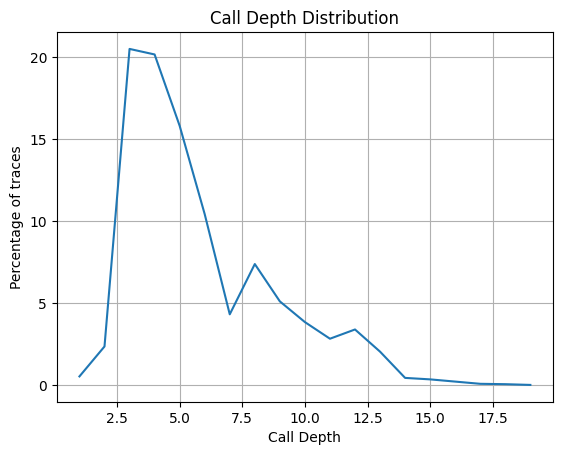

In [76]:
valid_cds = [x[0] for x in cd_percent_arr]
cd_percentages = [x[1] for x in cd_percent_arr]
plt.plot(valid_cds, cd_percentages)
plt.grid(True)
plt.xlabel('Call Depth')
plt.ylabel('Percentage of traces')
plt.title('Call Depth Distribution')
# plt.savefig('figs/cd_distribution_from_rpcids.png')
plt.show()

In [85]:
'''
NIS: Priority Sampling
'''
n = 600 # Reduced num of nodes (USER DEFINED)
# Sorted nis_dict based on NIS values
nid_nis_arr = [[nid, nis] for nid, nis in nis_dict.items()]
sorted_node_items = sorted(nid_nis_arr, key=lambda item: item[1], reverse=True)
sampled_nodes = []

for node in sorted_node_items[:n]:
    sampled_nodes.append(node[0])
    
print(len(sampled_nodes))
# nid_nis_arr_sorted_dict = dict(sorted_node_items)
# sampled_nodes = list(nid_nis_arr_sorted_dict.keys()[:n]) # List of selected node ids

600
600


In [78]:
'''
TIS: Priority Sampling
'''
t_red = 2200 # reduced num of traces (USER DEFINED)
sampled_tids_inter = [] # T_inter


# Priority sampling based on TIS
cd_ctr = 0
for cd in cd_percent_arr: 
    num_traces_to_sample_for_cd = int(t_red * cd[1]/100)
    
    if num_traces_to_sample_for_cd < 1:
        cd_ctr += 1 
        continue
    cd_traces_list = cd_strat_dict[cd[0]]
    cd_priority_sample = cd_traces_list[:num_traces_to_sample_for_cd]
    sampled_cd_tids = [x[0] for x in cd_priority_sample]
    sampled_tids_inter.extend(sampled_cd_tids)
    # print(cd_priority_sample)
print(cd_ctr)

1


In [79]:
print(sampled_tids_inter[:3])

['0b5118c915919476975793000e208f', '0b142ae215919659458786000e680b', '0b51195e15919324875023000e29e6']


In [94]:
'''
NODE PRUNING
Remove all nodes from T_inter that is not in sampled_nodes
'''

def cycle_func(A, B, pred_flag):
    # Cycle through B if it's shorter than A
    B_cycle = cycle(B)
    # Create tuples by pairing elements from A with elements from the cycled B
    if pred_flag == 1: # pred flag is used to check if direction is from pred to succ
        result = [(a, next(B_cycle)) for a in A]
    else:
        result = [(next(B_cycle), a) for a in A]
    return result


def remove_node_with_reconnect(G, node):
    '''
    Remove given node and check if graph breaks. If yes, connect pred nodes
    to succ nodes and then remove given node.
    returns: Updated graph after removing the given node
    '''
    num_comp_before_removal = len(list(nx.weakly_connected_components(G)))
    G_temp = G.copy()
    G_temp.remove_node(node)
    num_comp_after_removal = len(list(nx.weakly_connected_components(G_temp)))

    # If bridge node
    if num_comp_after_removal > num_comp_before_removal:
        pred_nodes = list(G.predecessors(node))
        succ_nodes = list(G.successors(node))
        if len(succ_nodes) == 0 or len(pred_nodes) == 0: # if leaf node
            G.remove_node(node)
            return G
        if len(pred_nodes) >= len(succ_nodes):
            edges_to_add = cycle_func(pred_nodes, succ_nodes, 1)
        else:
            edges_to_add = cycle_func(succ_nodes, pred_nodes, 0)
        for edge in edges_to_add:
            G.add_edge(edge[0], edge[1])
    
    # If not bridge 
    G.remove_node(node)

    return G

def prune_nodes_testy(sampled_tids_inter, sampled_nodes, df):
    '''
    Args: sampled_tids_inter= list of selected trace ids,
          sampled_nodes= list of selected node ids
    Returns: two Dicts(original & pruned); Key=tid, Val=list of edges to build tid
    '''
    T_prime = {}
    T_original = {}
    ctr = 0
    check_unique_nodes = []
    nodes_removed_per_trace = []
    unique_nodes_removed = []

    for tid in tqdm(sampled_tids_inter):
        ctr += 1
        nodes_to_remove = []# get list of nodes to remove in trace
        tid_calls = extract_traceid_rows(df, tid)
        t_edges = []
        for call in tid_calls:
            t_edges.append([call.um, call.dm])
            if call.um not in check_unique_nodes:
                check_unique_nodes.append(call.um)
            if call.dm not in check_unique_nodes:
                check_unique_nodes.append(call.dm)
            
        # Build pre-pruned graph
        G = nx.DiGraph()
        G.add_edges_from(t_edges)
        T_original[tid] = t_edges

        # Handling broken graphs (~40% are broken)
        num_comp_before_removal = len(list(nx.weakly_connected_components(G)))
        if num_comp_before_removal > 1:
            # select the largest component
            largest_comp = max(nx.weakly_connected_components(G), key=len)
            G = G.subgraph(largest_comp).copy()

        for node in G.nodes():
            if node not in sampled_nodes:
                nodes_to_remove.append(node)
        
        # nodes_to_remove = list(set(nodes_to_remove))
        nodes_removed_per_trace.append(len(nodes_to_remove))

        # Do node pruning
        for node in nodes_to_remove:
            if node in G:
                if node not in unique_nodes_removed:
                    unique_nodes_removed.append(node)
                G = remove_node_with_reconnect(G, node)

        # edges in pruned trace 
        all_edges = list(G.edges())
        T_prime[tid] = all_edges

    print('Sampled num of nodes: ', len(sampled_nodes))
    print('Sampled traces count: ', len(sampled_tids_inter))
    print('Unique nodes in selected tids: ', len(check_unique_nodes))
    print('Unique nodes removed: ', len(unique_nodes_removed))
    print('Total nodes removed(sum:max:min): ', sum(nodes_removed_per_trace), ':', max(nodes_removed_per_trace), ':', min(nodes_removed_per_trace))
    # print('Number of broken traces: ', len(broken_traces))
    return T_prime, T_original




In [95]:
# Pruning Check
T_prime, T_original = prune_nodes_testy(sampled_tids_inter, sampled_nodes, df)
# print(len(sampled_nodes))
save_dict_as_pkl(T_prime, 'downsampled_graphs/600nodes_2200traces')

100%|██████████| 2189/2189 [00:22<00:00, 97.52it/s] 

Sampled num of nodes:  600
Sampled traces count:  2189
Unique nodes in selected tids:  628
Unique nodes removed:  265
Total nodes removed(sum:max:min):  343 : 11 : 0


In [82]:
def buildg_from_tracesdict(traces_dict):

    full_graph_edge_list = []
    for edge_list in traces_dict.values():
        full_graph_edge_list.extend(edge_list)
    G = nx.DiGraph()
    G.add_edges_from(full_graph_edge_list)
    return G

G_prime = buildg_from_tracesdict(T_prime)
G_original = buildg_from_tracesdict(T_original)
print(len(G_original.nodes()))
print(len(G_prime.nodes()))

628
359


In [97]:
total = 0
valid = 0
for node in sampled_nodes:
    total += 1
    if node in G_original.nodes():
        valid += 1
print(total)
print(valid)


600
359


In [70]:
# Checking if initial nodes recorded is in pruned traces
T_details = pkl_to_dict('downsampled_graphs/trace_details_data.pkl') 
valid_ini = 0
for tid, edge_list in T_prime.items():
    G = nx.DiGraph()
    G.add_edges_from(edge_list)
    ini_node = T_details[tid][2]
    if ini_node in G.nodes():
        valid_ini += 1

print(valid_ini)

   

2492
